## Data/Text Mining Project


Course: CISD 43<br>
Professor: Sohair Zaki<br>
Student: Fiona Xu and Jack Chen<br>
<br>
Purpose:<br>
- hello world
<br>

Details:<br>
1. Load libraries, data cleaning<br>
2. Exploratory Data Analysis (EDA)<br>
3. Deep Learning<br>
4. Conclusion<br>
5. References<br>

## Libraries, Functions, Load/Cleaning Data

### Load Libraries

In [96]:
# Parsing Part
import requests
from bs4 import BeautifulSoup
# Alpha Vantage API - stock data
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.cryptocurrencies import CryptoCurrencies
from alpha_vantage.techindicators import TechIndicators

# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set_style("whitegrid")

# Deep Learning
import tensorflow
import keras.layers

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Model Featuring
from keras.layers import Input, Flatten, Dense, Activation, LeakyReLU, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor

# Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from keras import Sequential, Model

# Analyze Results
from sklearn.metrics import roc_curve, plot_roc_curve, r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn import metrics

# Misc
# filter warnings
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, History   
import pickle

import datetime as dt
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")


### Functions

In [3]:
# Function to clean balance sheet df
def convMonth(x):
    if x == 'MAR':
        x = 3
    elif x == 'DEC':
        x = 12
    elif x =='JUN':
        x = 6
    elif x == 'SEP':
        x = 9
    return x

In [4]:
# Function - ML - run machine learning model and print out MSE
def runML(model,feature,target,ftest,ttest):
    model.fit(feature, target)
    t_predict = model.predict(ftest)
    print(model)
    print('MAE score:', mean_absolute_error(ttest,t_predict))
    print('MSE score:', mean_squared_error(ttest,t_predict))
    print('R2 score:', r2_score(ttest,t_predict))
    print('')

In [5]:
# Convert to sequence function for TimeSeries to seq models 
def convSeq(feature, target, seq):
    Xs, ys = [],[]
    
    # from 0 to (len - seq)
    for i in range(len(feature) - seq):

        # from i to (i + seq)
        v = feature.iloc[i:(i+seq)]
        Xs.append(v)

        # target of (i+seq)
        ys.append(target.iloc[i+seq])
    return np.array(Xs), np.array(ys)

In [6]:
# Convert sequence dimenstions
def convDim(feature, target):
    targetArray = np.array(target)
    targetNew = targetArray.reshape(-1,1)
    featureArray = np.array(feature)
    featureNew = featureArray.reshape(featureArray.shape[0], featureArray.shape[1], 1)
    return featureNew, targetNew

In [84]:
# didnt work...

def hyperLSTM(units=32,activation='relu',optimizer='adam'):
    x=Xt
    ls = Sequential()
    ls.add(LSTM(units=32,activation=activation,return_sequences=True,input_shape=(x.shape[1],x.shape[2]),input_dim=3))
    ls.add(LSTM(units=32/2, activation=activation, input_shape=(x[1],units)))
    ls.add(Dense(units=3, activation = activation))
    ls.add(Dense(units=1, activation = activation))
    ls.compile(optimizer=optimizer, loss='mse',metrics=['mse','mae'])
    return ls

### AlphaVantage API

In [ ]:
# Variable - store Alpha Vantage API key
# path =  r'C:\Users\Gumo\Desktop\Git\Notebook\keys\alphaVantage.txt'
# with open(path, mode='r') as w:
#     key = (w.readline())

In [ ]:
# URL Method
# def alpha(function, symbol):
#     url = 'https://www.alphavantage.co/query?function='+function+'&symbol='+symbol+'&apikey='+key
#     response = requests.get(url)

# Function AlphaVantage
def alpha(symbol, function, period=None, typ = None, tim=None):
    
    # Funciton - TimeSeries
    if function == 't':
        # Instance - TimeSeries Instance
        ts = TimeSeries(key = key, output_format='pandas')
        if period == 'd':
            data = ts.get_daily_adjusted(symbol, outputsize=outputsize)[0]
        elif period == 'w':
            data = ts.get_weekly_adjusted(symbol)[0]
        elif period == 'm':
            data = ts.get_monthly_adjusted(symbol)[0]

    # Funciton - FundamentalData
    elif function == 'f':
        # Instance - FundamentalData Instance
        fd = FundamentalData(key, output_format='pandas')
        if period == 'q':
            if typ == 'i':
                data = fd.get_income_statement_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ == 'b':
                data = fd.get_balance_sheet_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ=='c':
                data = fd.get_cash_flow_quarterly(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
        elif period =='a':
            if typ == 'i':
                data = fd.get_income_statement_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ == 'b':
                data = fd.get_balance_sheet_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
            elif typ=='c':
                data = fd.get_cash_flow_annual(symbol)[0]
                data.index = data.iloc[:,0]
                data=data.iloc[:,2:]
    
    # Funciton - TechnicalIndicator            
    elif function =='ti':
        ti = TechIndicators(key,output_format='pandas')

        # reassign period into TI format
        if period == 'm':
            period = 'monthly'
        elif period =='w':
            period = 'weekly'
        elif period == 'd':
            period ='daily'

        if typ == 'rsi':
            data=ti.get_rsi(symbol,interval=period,time_period=tim,series_type='close')[0]
        elif typ =='so':
            data = ti.get_stoch(symbol,interval=period)[0]
            
    # Funciton - CC
    elif function == 'c':
        # Instance - Crypto
        cc = CryptoCurrencies(key, output_format='pandas')
        pass
    return data

In [ ]:
# Variable Size
outputsize = 'compact'

# Variable Stock
symbol = 'cvx'

# Variable Function - t, f, c, ti (timeseries, financialdata, crypto, technical indicator)
function = 'ti'

# Variable Period
# TimeSeries: d,w,m,i (daily, weekly, monthly, interval(mins))
# Fundamental: q,a (quarterly,annually)
# Technical: d,w,m, (interval(mins))
period = 'm'

# Varible - Type
# Fundamental: i,b,c
# Technical: so,rsi
typ ='so'

# Varible - Time
tim = 60

info = alpha(symbol,function,period=period,typ = typ,tim=tim)
info.head()

In [ ]:
# save to local stock data
# info.to_csv('data/'+symbol.upper()+'stockPrice.csv')

### BeautifulSoup

#### Scrape Inflation

In [7]:
# Define a variable for the url of the site
site = "https://www.usinflationcalculator.com/inflation/current-inflation-rates/#:~:text=The%20annual%20inflation%20rate%20for,at%208%3A30%20a.m.%20ET"

In [8]:
# Making a get request and assign the result to a variable response
response = requests.get(site)

#Check that the response was processed correctly
response.status_code

200

In [9]:
# Extracting the HTML
#assign a variable html to response content.
html = response.content

# Checking that the reply is indeed an HTML code by inspecting the first 200 symbols
html[:200]

b'<!DOCTYPE html>\n<!--[if IE 7]>\n<html class="ie ie7" dir="ltr" lang="en-US"\n\tprefix="og: https://ogp.me/ns#" >\n<![endif]-->\n<!--[if IE 8]>\n<html class="ie ie8" dir="ltr" lang="en-US"\n\tprefix="og: https'

In [10]:
#Convert HTML to a BeautifulSoup object, using the default parser of html  
#Create a BeautifulSoup object and store it in a variable named soup.
soup = BeautifulSoup(html, "html.parser")

In [11]:
# The soup variable (BeautifulSoup object) we defined earlier can be seen as representing the whole document
soup

<!DOCTYPE html>

<!--[if IE 7]>
<html class="ie ie7" dir="ltr" lang="en-US"
	prefix="og: https://ogp.me/ns#" >
<![endif]-->
<!--[if IE 8]>
<html class="ie ie8" dir="ltr" lang="en-US"
	prefix="og: https://ogp.me/ns#" >
<![endif]-->
<!--[if !(IE 7) | !(IE 8) ]><!-->
<html dir="ltr" lang="en-US" prefix="og: https://ogp.me/ns#">
<!--<![endif]-->
<head>
<!-- Global site tag (gtag.js) - Google Analytics -->
<script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-2181571-7"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-2181571-7');
</script>
<meta charset="utf-8"/>
<meta content="width=device-width" name="viewport"/>
<link href="http://gmpg.org/xfn/11" rel="profile"/>
<link href="https://www.usinflationcalculator.com/xmlrpc.php" rel="pingback"/>
<!--[if lt IE 9]>
	<script src="https://www.usinflationcalculator.com/wp-content/themes/twentyfourteen/js/html5.js"></script>


In [ ]:
#using prettify() method to turn a Beautiful Soup parse tree into a nicely formatted Unicode string,
#with a separate line for each tag and each string:
print(soup.prettify())

<!DOCTYPE html>
<!--[if IE 7]>
<html class="ie ie7" dir="ltr" lang="en-US"
	prefix="og: https://ogp.me/ns#" >
<![endif]-->
<!--[if IE 8]>
<html class="ie ie8" dir="ltr" lang="en-US"
	prefix="og: https://ogp.me/ns#" >
<![endif]-->
<!--[if !(IE 7) | !(IE 8) ]><!-->
<html dir="ltr" lang="en-US" prefix="og: https://ogp.me/ns#">
 <!--<![endif]-->
 <head>
  <!-- Global site tag (gtag.js) - Google Analytics -->
  <script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-2181571-7">
  </script>
  <script>
   window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-2181571-7');
  </script>
  <meta charset="utf-8"/>
  <meta content="width=device-width" name="viewport"/>
  <link href="http://gmpg.org/xfn/11" rel="profile"/>
  <link href="https://www.usinflationcalculator.com/xmlrpc.php" rel="pingback"/>
  <!--[if lt IE 9]>
	<script src="https://www.usinflationcalculator.com/wp-content/themes/twentyfourteen/

In [12]:
# Exporting the HTML to a file
with open('output/inflation_rate_response.html', 'wb') as file:
    file.write(soup.prettify('utf-8'))

In [13]:
# creating list with all tables
tables = soup.find_all('table')

In [14]:
# Inspect the value of the variable
tables

[<table cellpadding="0" cellspacing="0" width="110%">
 <tr height="17">
 <td align="right" height="17"><strong>Year</strong></td>
 <td align="right"><strong>Jan</strong></td>
 <td align="right"><strong>Feb</strong></td>
 <td align="right"><strong>Mar</strong></td>
 <td align="right"><strong>Apr</strong></td>
 <td align="right"><strong>May</strong></td>
 <td align="right"><strong>Jun</strong></td>
 <td align="right"><strong>Jul</strong></td>
 <td align="right"><strong>Aug</strong></td>
 <td align="right"><strong>Sep</strong></td>
 <td align="right"><strong>Oct</strong></td>
 <td align="right"><strong>Nov</strong></td>
 <td align="right"><strong>Dec</strong></td>
 <td align="right"><strong>Ave</strong></td>
 </tr>
 <tr>
 <td align="right" height="17"><strong>2022</strong></td>
 <td align="right">7.5</td>
 <td align="right">7.9</td>
 <td align="right">8.5</td>
 <td align="right">8.3</td>
 <td align="right"><em>Avail.<br/>
      June<br/>
      10</em></td>
 <td align="right"> </td>
 <td a

In [15]:
#since there is only one table, set table as the first table in tables
table = tables[0]
#display table
table

<table cellpadding="0" cellspacing="0" width="110%">
<tr height="17">
<td align="right" height="17"><strong>Year</strong></td>
<td align="right"><strong>Jan</strong></td>
<td align="right"><strong>Feb</strong></td>
<td align="right"><strong>Mar</strong></td>
<td align="right"><strong>Apr</strong></td>
<td align="right"><strong>May</strong></td>
<td align="right"><strong>Jun</strong></td>
<td align="right"><strong>Jul</strong></td>
<td align="right"><strong>Aug</strong></td>
<td align="right"><strong>Sep</strong></td>
<td align="right"><strong>Oct</strong></td>
<td align="right"><strong>Nov</strong></td>
<td align="right"><strong>Dec</strong></td>
<td align="right"><strong>Ave</strong></td>
</tr>
<tr>
<td align="right" height="17"><strong>2022</strong></td>
<td align="right">7.5</td>
<td align="right">7.9</td>
<td align="right">8.5</td>
<td align="right">8.3</td>
<td align="right"><em>Avail.<br/>
     June<br/>
     10</em></td>
<td align="right"> </td>
<td align="right"> </td>
<td alig

In [16]:
# extracting all rows
table.find_all('tr')

[<tr height="17">
 <td align="right" height="17"><strong>Year</strong></td>
 <td align="right"><strong>Jan</strong></td>
 <td align="right"><strong>Feb</strong></td>
 <td align="right"><strong>Mar</strong></td>
 <td align="right"><strong>Apr</strong></td>
 <td align="right"><strong>May</strong></td>
 <td align="right"><strong>Jun</strong></td>
 <td align="right"><strong>Jul</strong></td>
 <td align="right"><strong>Aug</strong></td>
 <td align="right"><strong>Sep</strong></td>
 <td align="right"><strong>Oct</strong></td>
 <td align="right"><strong>Nov</strong></td>
 <td align="right"><strong>Dec</strong></td>
 <td align="right"><strong>Ave</strong></td>
 </tr>,
 <tr>
 <td align="right" height="17"><strong>2022</strong></td>
 <td align="right">7.5</td>
 <td align="right">7.9</td>
 <td align="right">8.5</td>
 <td align="right">8.3</td>
 <td align="right"><em>Avail.<br/>
      June<br/>
      10</em></td>
 <td align="right"> </td>
 <td align="right"> </td>
 <td align="right"> </td>
 <td al

In [17]:
#Gets all the column headers of our table
#create an empty list name it headers
headers = []
#loop through the first row which containts the header names
#save the text in the table header tag after stripping any extra spaces as title
#append this title to the headers list
for i in table.find_all('tr')[0]:
    title = i.text.strip()
    if title != '':
        headers.append(title)
        
#display headers in a list
headers

['Year',
 'Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec',
 'Ave']

In [18]:
#Creates a dataframe using the column headers from our table
df = pd.DataFrame(columns = headers)

#display the header in a dataframe
df

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ave


In [19]:
#create a for loop to iterate all the rows in the table
#retrieve the text in the row which is the value we want
#get the length of the dataframe
#populate the contents of the dataframe iteratively by reading each row 
#increment the length of the dataframe and add the row to the end of the dataframe
for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [tr.text for tr in row_data]
    length = len(df)
    df.loc[length] = row

In [20]:
#display the dataframe
df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ave
0,2022,7.5,7.9,8.5,8.3,Avail.\n June\n 10,,,,,,,,
1,2021,1.4,1.7,2.6,4.2,5.0,5.4,5.4,5.3,5.4,6.2,6.8,7.0,4.7
2,2020,2.5,2.3,1.5,0.3,0.1,0.6,1.0,1.3,1.4,1.2,1.2,1.4,1.2
3,2019,1.6,1.5,1.9,2.0,1.8,1.6,1.8,1.7,1.7,1.8,2.1,2.3,1.8
4,2018,2.1,2.2,2.4,2.5,2.8,2.9,2.9,2.7,2.3,2.5,2.2,1.9,2.4


In [21]:
# set year, month and inflaiton rate as the column name and remove unneeded value
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_inflation = pd.melt(df, id_vars = 'Year', value_vars=months,var_name='Month', value_name='Inflation Rate')
df_inflation['Month']=pd.Categorical(df_inflation['Month'], categories=months, ordered=True)
df_inflation.sort_values(by=['Year','Month'], inplace=True)

In [22]:
# display the head of the dataframe
df_inflation.head()

,Year,Month,Inflation Rate
22,2000,Jan,2.7
45,2000,Feb,3.2
68,2000,Mar,3.8
91,2000,Apr,3.1
114,2000,May,3.2


In [23]:
# save it to a csv file
# df_inflation.to_csv('data/inflation_rate_clean.csv')

#### Scrape the Gas Price Website

In [24]:
# Define a variable for the url of the site
site_gas = "https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=emm_epm0_pte_nus_dpg&f=m"

In [25]:
# Making a get request and assign the result to a variable response
response_gas = requests.get(site_gas)

#Check that the response was processed correctly
response_gas.status_code

200

In [26]:
# Extracting the HTML
#assign a variable html to response content.
html_gas = response_gas.content

# Checking that the reply is indeed an HTML code by inspecting the first 200 symbols
html_gas[:500]

b"<!DOCTYPE HTML PUBLIC '-//W3C//DTD HTML 4.01 Transitional//EN'>\r <html>\r <head>\r <meta http-equiv='X-UA-Compatible' content='IE=9' />\r <title>U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)</title>\r <script src='../includes/TableFloaterTitle.js'></script>\r <link rel='StyleSheet' href='../Styles/Pet_wrapper3.css' TYPE='text/css'>\r <link rel='StyleSheet' href='../Styles/leaf_new2.css' TYPE='text/css'>\r <link rel='StyleSheet' href='/styles/Eia_sitewideF.css' type='text/"

In [27]:
#Convert HTML to a BeautifulSoup object, using the default parser of html  
#Create a BeautifulSoup object and store it in a variable named soup.
soup_gas = BeautifulSoup(html_gas, "html.parser")

In [28]:
#using prettify() method to turn a Beautiful Soup parse tree into a nicely formatted Unicode string,
#with a separate line for each tag and each string:
print(soup_gas.prettify())

<!DOCTYPE HTML PUBLIC '-//W3C//DTD HTML 4.01 Transitional//EN'>
<html>
 <head>
  <meta content="IE=9" http-equiv="X-UA-Compatible"/>
  <title>
   U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)
  </title>
  <script src="../includes/TableFloaterTitle.js">
  </script>
  <link href="../Styles/Pet_wrapper3.css" rel="StyleSheet" type="text/css"/>
  <link href="../Styles/leaf_new2.css" rel="StyleSheet" type="text/css"/>
  <link href="/styles/Eia_sitewideF.css" rel="StyleSheet" type="text/css">
   <!-- Header Script -->
   <script language="JavaScript" src="/styles/eia_header.js" type="text/javascript">
   </script>
   <!--/ Header Script -->
   <script src="/global/includes/dnavs/leaf_handler.cfm" type="text/javascript">
   </script>
   <!-- Footer Script -->
   <script language="JavaScript" src="/styles/eia_footer.js" type="text/javascript">
   </script>
   <!--/ Footer Script -->
  </link>
 </head>
 <body>
  <script language="JavaScript" type="text/javascript">

In [29]:
# Exporting the HTML to a file
with open('output/gas_price.html', 'wb') as file:
    file.write(soup_gas.prettify('utf-8'))

In [30]:
# creating list with all tables
tables_gas = soup_gas.find_all('table')

In [31]:
tables_gas

[<table border="0" cellpadding="0" cellspacing="0" width="675"> <tr> <td class="K"> </td> </tr> <tr> <td height="12"></td> </tr> <tr> <td> <table border="0" cellpadding="0" cellspacing="0" width="675"> <tr> <td width="400"> <table border="2" bordercolordark="#6699cc" bordercolorlight="#6699cc" cellpadding="0" cellspacing="0" style="border: thin;"> <tr> <td> <table border="0" cellpadding="0" cellspacing="0"> <tr> <td class="J"> View History:  </td> <td><a href="LeafHandler.ashx?n=pet&amp;s=emm_epm0_pte_nus_dpg&amp;f=w"><img alt="" border="0" height="13" src="../img/RadioL_I.jpg" width="12"/></a></td> <td class="F"> <a class="NavChunk" href="LeafHandler.ashx?n=pet&amp;s=emm_epm0_pte_nus_dpg&amp;f=w">Weekly</a>   </td> <td><a href="LeafHandler.ashx?n=pet&amp;s=emm_epm0_pte_nus_dpg&amp;f=m"><img alt="" border="0" height="13" src="../img/RadioL_A.jpg" width="12"/></a></td> <td class="F"> <a class="NavChunk" href="LeafHandler.ashx?n=pet&amp;s=emm_epm0_pte_nus_dpg&amp;f=m">Monthly</a>   </td>

In [32]:
print('Classes of each table:')
for table in soup_gas.find_all('table'):
    print(table.get('class'))

Classes of each table:
None
None
None
None
None
None
['FloatTitle']
None
None


In [33]:
table_gas = soup_gas.find('table', class_='FloatTitle')

In [34]:
table_gas

<table border="0" cellpadding="2" cellspacing="0" class="FloatTitle" width="675"> <thead> <tr bgcolor="#993333"> <th class="G2">Year</th> <th class="G">Jan</th> <th class="G">Feb</th> <th class="G">Mar</th> <th class="G">Apr</th> <th class="G">May</th> <th class="G">Jun</th> <th class="G">Jul</th> <th class="G">Aug</th> <th class="G">Sep</th> <th class="G">Oct</th> <th class="G">Nov</th> <th class="G">Dec</th> </tr> </thead> <tbody> <tr> <td class="B4">  1993</td> <td class="B3"></td> <td class="B3"></td> <td class="B3"></td> <td class="B3">1.078</td> <td class="B3">1.100</td> <td class="B3">1.097</td> <td class="B3">1.078</td> <td class="B3">1.062</td> <td class="B3">1.050</td> <td class="B3">1.092</td> <td class="B3">1.066</td> <td class="B3">1.014</td> </tr> <tr> <td class="B4">  1994</td> <td class="B3">0.998</td> <td class="B3">1.009</td> <td class="B3">1.008</td> <td class="B3">1.027</td> <td class="B3">1.047</td> <td class="B3">1.078</td> <td class="B3">1.106</td> <td class="B3"

In [35]:
# extracting all rows
table_gas.find_all('tr')

[<tr bgcolor="#993333"> <th class="G2">Year</th> <th class="G">Jan</th> <th class="G">Feb</th> <th class="G">Mar</th> <th class="G">Apr</th> <th class="G">May</th> <th class="G">Jun</th> <th class="G">Jul</th> <th class="G">Aug</th> <th class="G">Sep</th> <th class="G">Oct</th> <th class="G">Nov</th> <th class="G">Dec</th> </tr>,
 <tr> <td class="B4">  1993</td> <td class="B3"></td> <td class="B3"></td> <td class="B3"></td> <td class="B3">1.078</td> <td class="B3">1.100</td> <td class="B3">1.097</td> <td class="B3">1.078</td> <td class="B3">1.062</td> <td class="B3">1.050</td> <td class="B3">1.092</td> <td class="B3">1.066</td> <td class="B3">1.014</td> </tr>,
 <tr> <td class="B4">  1994</td> <td class="B3">0.998</td> <td class="B3">1.009</td> <td class="B3">1.008</td> <td class="B3">1.027</td> <td class="B3">1.047</td> <td class="B3">1.078</td> <td class="B3">1.106</td> <td class="B3">1.155</td> <td class="B3">1.144</td> <td class="B3">1.114</td> <td class="B3">1.119</td> <td class="B

In [36]:
# Inspecting the contents of first row
table_gas.find_all('tr')[0].contents

[' ',
 <th class="G2">Year</th>,
 ' ',
 <th class="G">Jan</th>,
 ' ',
 <th class="G">Feb</th>,
 ' ',
 <th class="G">Mar</th>,
 ' ',
 <th class="G">Apr</th>,
 ' ',
 <th class="G">May</th>,
 ' ',
 <th class="G">Jun</th>,
 ' ',
 <th class="G">Jul</th>,
 ' ',
 <th class="G">Aug</th>,
 ' ',
 <th class="G">Sep</th>,
 ' ',
 <th class="G">Oct</th>,
 ' ',
 <th class="G">Nov</th>,
 ' ',
 <th class="G">Dec</th>,
 ' ']

In [37]:
#Gets all the column headers of our table
#create an empty list name it headers
headers_gas = []
#loop through the first row which containts the header names
#save the text in the table header tag after stripping any extra spaces as title
#append this title to the headers list
for i in table_gas.find_all('th'):
    title = i.text.strip()
    if title != '':
        headers_gas.append(title)
        
#display headers in a list
headers_gas

['Year',
 'Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec']

In [38]:
#Creates a dataframe using the column headers from our table
df_gas = pd.DataFrame(columns = headers_gas[:14])

#display the header in a dataframe
df_gas

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec


In [39]:
# Get all the rows of table_gas
# create an empty table that will store all the data 
table_data=[]
for tr in table_gas.find_all('tr'):
    t_row={}
    #Each table row is stored in the form of 
    #t_row= {'Year': '', 'Jan': '', 'Feb': ''......'Dec': ''}
    
    #find all td's(13) in tr and zip it with headers_gas
    for td, th in zip(tr.find_all('td'), headers_gas):
        t_row[th] = td.text.strip()
    table_data.append(t_row)

In [40]:
# display table_data
table_data

[{},
 {'Year': '1993',
  'Jan': '',
  'Feb': '',
  'Mar': '',
  'Apr': '1.078',
  'May': '1.100',
  'Jun': '1.097',
  'Jul': '1.078',
  'Aug': '1.062',
  'Sep': '1.050',
  'Oct': '1.092',
  'Nov': '1.066',
  'Dec': '1.014'},
 {'Year': '1994',
  'Jan': '0.998',
  'Feb': '1.009',
  'Mar': '1.008',
  'Apr': '1.027',
  'May': '1.047',
  'Jun': '1.078',
  'Jul': '1.106',
  'Aug': '1.155',
  'Sep': '1.144',
  'Oct': '1.114',
  'Nov': '1.119',
  'Dec': '1.129'},
 {'Year': ''},
 {'Year': '1995',
  'Jan': '1.130',
  'Feb': '1.120',
  'Mar': '1.119',
  'Apr': '1.157',
  'May': '1.225',
  'Jun': '1.239',
  'Jul': '1.201',
  'Aug': '1.170',
  'Sep': '1.158',
  'Oct': '1.134',
  'Nov': '1.109',
  'Dec': '1.118'},
 {'Year': '1996',
  'Jan': '1.137',
  'Feb': '1.136',
  'Mar': '1.183',
  'Apr': '1.275',
  'May': '1.324',
  'Jun': '1.300',
  'Jul': '1.272',
  'Aug': '1.251',
  'Sep': '1.247',
  'Oct': '1.249',
  'Nov': '1.278',
  'Dec': '1.282'},
 {'Year': '1997',
  'Jan': '1.283',
  'Feb': '1.276',
 

In [41]:
# create a dataframe called df_gas and store table_data in it
df_gas = pd.DataFrame(table_data)

# display df_gas
df_gas

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993,,,,1.078,1.100,1.097,1.078,1.062,1.050,1.092,1.066,1.014
2,1994,0.998,1.009,1.008,1.027,1.047,1.078,1.106,1.155,1.144,1.114,1.119,1.129
3,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1995,1.130,1.120,1.119,1.157,1.225,1.239,1.201,1.170,1.158,1.134,1.109,1.118
5,1996,1.137,1.136,1.183,1.275,1.324,1.300,1.272,1.251,1.247,1.249,1.278,1.282
6,1997,1.283,1.276,1.251,1.244,1.245,1.242,1.220,1.268,1.276,1.242,1.216,1.177
7,1998,1.132,1.096,1.064,1.077,1.105,1.103,1.094,1.065,1.049,1.059,1.036,0.987
8,1999,0.980,0.962,1.022,1.171,1.171,1.154,1.197,1.260,1.295,1.285,1.292,1.313
9,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#remove all the rows that contain null values
df_gas = df_gas.dropna()
df_gas

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1,1993,,,,1.078,1.100,1.097,1.078,1.062,1.050,1.092,1.066,1.014
2,1994,0.998,1.009,1.008,1.027,1.047,1.078,1.106,1.155,1.144,1.114,1.119,1.129
4,1995,1.130,1.120,1.119,1.157,1.225,1.239,1.201,1.170,1.158,1.134,1.109,1.118
5,1996,1.137,1.136,1.183,1.275,1.324,1.300,1.272,1.251,1.247,1.249,1.278,1.282
6,1997,1.283,1.276,1.251,1.244,1.245,1.242,1.220,1.268,1.276,1.242,1.216,1.177
7,1998,1.132,1.096,1.064,1.077,1.105,1.103,1.094,1.065,1.049,1.059,1.036,0.987
8,1999,0.980,0.962,1.022,1.171,1.171,1.154,1.197,1.260,1.295,1.285,1.292,1.313
10,2000,1.329,1.415,1.556,1.506,1.526,1.666,1.591,1.506,1.588,1.571,1.557,1.483
11,2001,1.487,1.490,1.450,1.591,1.738,1.658,1.466,1.461,1.557,1.357,1.212,1.127
12,2002,1.148,1.155,1.289,1.439,1.434,1.424,1.438,1.438,1.441,1.486,1.461,1.429


In [43]:
# drop data in year 1993-1999 and Apr in 2022
df_gas = df_gas.drop([1, 2, 4, 5, 6, 7, 8])

In [53]:
# change the format of the dataframe
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df_gas_new = pd.melt(df_gas, id_vars = 'Year', value_vars=months, var_name='Month', value_name='Gas Price')

df_gas_new['Month']=pd.Categorical(df_gas_new['Month'], categories=months, ordered=True)
df_gas_new.sort_values(by=['Year','Month'], inplace=True)
df_gas_new

,Year,Month,Gas Price
0,2000,Jan,1.329
23,2000,Feb,1.415
46,2000,Mar,1.556
69,2000,Apr,1.506
92,2000,May,1.526
...,...,...,...
183,2022,Aug,
206,2022,Sep,
229,2022,Oct,
252,2022,Nov,


### Load/Clean Data

In [54]:
# load dfs - data will be 01/2000 to 03/2022, 22 years and 3 month is 267 month, 
df_bs = pd.read_excel('data/df_cvx_bs_quarter.xlsx', engine='openpyxl')
df_is = pd.read_excel('data/df_cvx_is_quarter.xlsx', engine='openpyxl')
df_stock = pd.read_csv('data/CVXstockPrice.csv')
df_inflation = pd.read_csv('data/clean_inflation_rate.csv')
df_gas = pd.read_excel('data/gasPrices.xlsx', engine='openpyxl')




### Clean merged dataframe

Stcok DF

In [ ]:
# we just need adjusted close , volumn
dfstock1 = df_stock.iloc[:,[0,5,6]]

# create year column and month column
dfstock1['year'] = df_stock.date.apply(lambda x : x.split('-')[0])
dfstock1['month'] = df_stock.date.apply(lambda x : x.split('-')[1])
dfstock1.tail()

# drop useless columns
dfstock2 = dfstock1.iloc[2:-1,1:]
# reset index
dfstock3 = dfstock2.reset_index(drop=True)

# convert month into int
dfstock3.month = dfstock3.month.apply(lambda x: int(x))

#assign to finaldf
dfstockf = dfstock3.sort_values(by=['year','month'])
dfstockf

Balance Sheet DF

In [ ]:
# df_BalanceSheet - Clean Balance Sheet
# transpose df
df_bs1 = df_bs.T

# assign column names
df_bs1.columns = df_bs1.iloc[0,:]

# reset index and drop first row
df_bs2 = df_bs1.reset_index().iloc[1:,:]
df_bs2.head(3)

Unnamed: 0,index,Cash & Short-Term Investments,Cash Only,Total Short Term Investments,Short-Term Receivables,"Accounts Receivables, Net","Accounts Receivables, Gross",Bad Debt/Doubtful Accounts,Other Receivables,Inventories,...,Other Appropriated Reserves,Treasury Stock,Repurchased Stock Value,Total Shareholders' Equity,Accumulated Minority Interest,Total Equity,Total Liabilities & Shareholders' Equity,Per Share,Book Value per Share,Tangible Book Value per Share
1,MAR '22,12.02,11.99,0.03,23.26,23.2,23.51,-0.3,0.05,6.53,...,-3.71,-39.16,1.25,146.22,0.88,147.1,249.05,NaN,74.42,72.19
2,DEC '21,6.01,5.97,0.04,18.42,18.17,18.47,-0.3,0.25,6.31,...,-3.96,-41.46,0.75,139.07,0.87,139.94,239.54,NaN,72.06,69.79
3,SEP '21,6.28,6.24,0.03,16.57,16.16,16.45,-0.29,0.4,6.13,...,-4.51,-41.42,0.63,135.86,0.86,136.72,239.95,NaN,70.48,68.2


In [ ]:
# see the columns
df_bs2.columns

Index(['index', 'Cash & Short-Term Investments', 'Cash Only',
       'Total Short Term Investments', 'Short-Term Receivables',
       'Accounts Receivables, Net', 'Accounts Receivables, Gross',
       'Bad Debt/Doubtful Accounts', 'Other Receivables', 'Inventories',
       'Finished Goods', 'Raw Materials', 'Other Current Assets',
       'Miscellaneous Current Assets', 'Total Current Assets',
       'Net Property, Plant & Equipment',
       'Property, Plant & Equipment - Gross',
       'Operating Lease Right-of-Use Assets', 'Accumulated Depreciation',
       'Total Long-Term Investments ', 'LT Investment - Affiliate Companies',
       'Other Long-Term Investments', 'Long-Term Note Receivable',
       'Intangible Assets', 'Goodwill', 'Deferred Tax Assets', 'Other Assets',
       'Tangible Other Assets', 'Total Assets',
       'Liabilities & Shareholders' Equity', 'ST Debt & Curr. Portion LT Debt',
       'Accounts Payable', 'Income Tax Payable', 'Other Current Liabilities',
       'Misc

In [ ]:
# select the needed columns
df_bs3 = df_bs2[['index','Total Assets', 'Total Equity']].iloc[:89,:]
df_bs3.shape

Unnamed: 0,index,Total Assets,Total Equity
1,MAR '22,249.05,147.1
2,DEC '21,239.54,139.94
3,SEP '21,239.95,136.72
4,JUN '21,242.81,133.91
5,MAR '21,241.65,132.93


In [ ]:
# since data is quarterly, we will append the data until we have 267 month
dfbs4 = df_bs3
dfbs5 = dfbs4.append(df_bs3)
dfbs6 = dfbs5.append(df_bs3)
dfbs6.shape

In [ ]:
# convert year and month
dfbs6['year'] = dfbs6['index'].apply(lambda x : int(x.split(' \'')[1]) + 2000)
dfbs6['month'] = dfbs6['index'].apply(lambda x : convMonth(x.split(' \'')[0]))
dfbs6.head()

In [ ]:
dfbsf = dfbs6.sort_values(by=['year','month'])
dfbsf.shape

Income Statement DF

In [ ]:
# Income Statement - Clean Balance Sheet
# transpose df
df_is1 = df_is.T

# assign column names
df_is1.columns = df_is1.iloc[0,:]

# reset index and drop first row
df_is2 = df_is1.reset_index().iloc[1:,:]
df_is2.head(3)

In [ ]:
# see the columns
df_is2.columns

In [ ]:
# select needed columns
df_is3 = df_is2[['index','Sales','Net Income']].iloc[:89,:]
df_is3.shape

In [ ]:
# append df to 267 month
dfis4 = df_is3
dfis5 = dfis4.append(df_is3)
dfis6 = dfis5.append(df_is3)


In [ ]:
# 22 year 3 month = 267 month
dfis6.shape

In [ ]:
# create year and month columns
dfis6['year'] = dfis6['index'].apply(lambda x : int(x.split(' \'')[1]) + 2000)
dfis6['month'] = dfis6['index'].apply(lambda x : convMonth(x.split(' \'')[0]))
dfis6.head()

In [ ]:
# sort by values
dfisf = dfis6.sort_values(by=['year','month'])
dfisf.shape

Inflation DF

In [ ]:
# format inflation df
dfi1 = df_inflation.iloc[:267,:]
dfi1

Gas DF

In [ ]:
df_gas.Date = df_gas.Date.astype(str)

In [ ]:
df_gas['year'] = df_gas.Date.apply(lambda x : x.split('-')[0])
df_gas['month'] = df_gas.Date.apply(lambda x : x.split('-')[1])
df_gas

In [ ]:
# get dfgas1
dfgas1 = df_gas.iloc[81:,:]

In [ ]:
# create merged df
dfmerge = dfstockf

#rewrite quartly month into 12 month
dfmerge['sales'] = list(dfisf.Sales)
dfmerge['netIncome'] = list(dfisf['Net Income'])
dfmerge['Total Assets'] = list(dfbsf['Total Assets'])
dfmerge['Total Equity'] = list(dfbsf['Total Equity'])
dfmerge['inflation'] = list(dfi1['Inflation Rate'])
dfmerge['gas'] = list(dfgas1['U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)'])

# create the dfmerge1 reset index, rename columns
dfmerge1 = dfmerge.reset_index(drop=True).rename(columns={'5. adjusted close':'adjustedClose','6. volume':'volume','Total Assets': 'assets','Total Equity': 'equity'})

''' Units
sales - millions
netIncome - millions
asset - billions
equity - billions

'''

# assign new df
dfmerge2 = dfmerge1

# convert into millions
dfmerge2.equity = dfmerge1.equity * 1000
dfmerge2.assets = dfmerge1.assets * 1000
# convert into 3 month average
dfmerge2.sales = dfmerge1.sales/3
dfmerge2.netIncome = dfmerge1.netIncome/3
dfmerge2.year = dfmerge2.year.astype(int)
dfmerge2.inflation = dfmerge2.inflation.astype(float)

In [ ]:
dfmerge2.info()

In [ ]:
# save to csv
# dfmerge2.to_csv('data/final_df.csv')

#### Make Final DF after cleaning

In [61]:
# read csv file into a dataframe
df_merge = pd.read_csv('data/final_df.csv', index_col=0)

# change the column names
df_merge.rename(columns = {'adjustedClose':'AdjustedClose', 'volume':'Volume', 'year':'Year', 'month':'Month', 
                           'sales':'Sales', 'netIncome':'NetIncome','assets':'Assets', 'equity':'Equity','inflation':'InflationRate',
                           'gas':'GasPrice'}, inplace = True)

# show the renamed dataframe
df_merge


,AdjustedClose,Volume,Year,Month,Sales,NetIncome,Assets,Equity,InflationRate,GasPrice
0,18.2953,37687500.0,2000,1,3481.000000,348.000000,41250.0,18010.0,2.7,1.329
1,16.4760,42961800.0,2000,2,3481.000000,348.000000,41250.0,18010.0,3.2,1.415
2,20.3915,51176100.0,2000,3,3481.000000,348.000000,41250.0,18010.0,3.8,1.556
3,18.7790,31502600.0,2000,4,3987.333333,372.000000,41380.0,18750.0,3.1,1.506
4,20.5234,30692800.0,2000,5,3987.333333,372.000000,41380.0,18750.0,3.2,1.526
...,...,...,...,...,...,...,...,...,...,...
262,110.7529,224686287.0,2021,11,15402.333333,1685.000000,239540.0,139940.0,6.8,3.491
263,115.1489,221128758.0,2021,12,15402.333333,1685.000000,239540.0,139940.0,7.0,3.406
264,128.8667,300049707.0,2022,1,17729.000000,2086.333333,249050.0,147100.0,7.5,3.413
265,142.7935,282783725.0,2022,2,17729.000000,2086.333333,249050.0,147100.0,7.9,3.611


In [62]:

# reorder the column
df_merge=df_merge[['Year', 'Month', 'InflationRate', 'GasPrice', 'Sales', 'NetIncome', 'Assets', 'Equity',
             'Volume', 'AdjustedClose']]
# display the final dataframe
df_merge.head()



,Year,Month,InflationRate,GasPrice,Sales,NetIncome,Assets,Equity,Volume,AdjustedClose
0,2000,1,2.7,1.329,3481.000000,348.0,41250.0,18010.0,37687500.0,18.2953
1,2000,2,3.2,1.415,3481.000000,348.0,41250.0,18010.0,42961800.0,16.4760
2,2000,3,3.8,1.556,3481.000000,348.0,41250.0,18010.0,51176100.0,20.3915
3,2000,4,3.1,1.506,3987.333333,372.0,41380.0,18750.0,31502600.0,18.7790
4,2000,5,3.2,1.526,3987.333333,372.0,41380.0,18750.0,30692800.0,20.5234


In [63]:
# change the volume unit to million 
df_merge.Volume = df_merge.Volume/1000000
df_merge



,Year,Month,InflationRate,GasPrice,Sales,NetIncome,Assets,Equity,Volume,AdjustedClose
0,2000,1,2.7,1.329,3481.000000,348.000000,41250.0,18010.0,37.687500,18.2953
1,2000,2,3.2,1.415,3481.000000,348.000000,41250.0,18010.0,42.961800,16.4760
2,2000,3,3.8,1.556,3481.000000,348.000000,41250.0,18010.0,51.176100,20.3915
3,2000,4,3.1,1.506,3987.333333,372.000000,41380.0,18750.0,31.502600,18.7790
4,2000,5,3.2,1.526,3987.333333,372.000000,41380.0,18750.0,30.692800,20.5234
...,...,...,...,...,...,...,...,...,...,...
262,2021,11,6.8,3.491,15402.333333,1685.000000,239540.0,139940.0,224.686287,110.7529
263,2021,12,7.0,3.406,15402.333333,1685.000000,239540.0,139940.0,221.128758,115.1489
264,2022,1,7.5,3.413,17729.000000,2086.333333,249050.0,147100.0,300.049707,128.8667
265,2022,2,7.9,3.611,17729.000000,2086.333333,249050.0,147100.0,282.783725,142.7935


In [64]:
#formatting float column
#change the value of sales column to two decimal digits 
df_merge[['Sales', 'NetIncome']]=df_merge[['Sales', 'NetIncome']].round(decimals=2)
# display the cleaned dataframe
df_merge



,Year,Month,InflationRate,GasPrice,Sales,NetIncome,Assets,Equity,Volume,AdjustedClose
0,2000,1,2.7,1.329,3481.00,348.00,41250.0,18010.0,37.687500,18.2953
1,2000,2,3.2,1.415,3481.00,348.00,41250.0,18010.0,42.961800,16.4760
2,2000,3,3.8,1.556,3481.00,348.00,41250.0,18010.0,51.176100,20.3915
3,2000,4,3.1,1.506,3987.33,372.00,41380.0,18750.0,31.502600,18.7790
4,2000,5,3.2,1.526,3987.33,372.00,41380.0,18750.0,30.692800,20.5234
...,...,...,...,...,...,...,...,...,...,...
262,2021,11,6.8,3.491,15402.33,1685.00,239540.0,139940.0,224.686287,110.7529
263,2021,12,7.0,3.406,15402.33,1685.00,239540.0,139940.0,221.128758,115.1489
264,2022,1,7.5,3.413,17729.00,2086.33,249050.0,147100.0,300.049707,128.8667
265,2022,2,7.9,3.611,17729.00,2086.33,249050.0,147100.0,282.783725,142.7935


In [65]:
# save it to a csv file
# df_merge.to_csv('data/df_final_merge.csv')

## Exploratory Data Analysis (EDA)

In [8]:
df_merge = pd.read_csv('data/df_final_merge.csv',index_col=0)

In [9]:
# Get the basic information about the data
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 0 to 266
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           267 non-null    int64  
 1   Month          267 non-null    int64  
 2   InflationRate  267 non-null    float64
 3   GasPrice       267 non-null    float64
 4   Sales          267 non-null    float64
 5   NetIncome      267 non-null    float64
 6   Assets         267 non-null    float64
 7   Equity         267 non-null    float64
 8   Volume         267 non-null    float64
 9   AdjustedClose  267 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 22.9 KB


In [10]:
# Get the statistics of the data
df_merge.describe()

,Year,Month,InflationRate,GasPrice,Sales,NetIncome,Assets,Equity,Volume,AdjustedClose
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,2010.629213,6.449438,2.310487,2.586599,13405.051910,1021.059213,179078.202247,100914.044944,159.266501,58.870619
std,6.436004,3.472809,1.500965,0.745405,5095.207885,911.020372,75466.124685,48334.965201,85.342422,30.419139
min,2000.000000,1.000000,-2.100000,1.127000,3481.000000,-2756.670000,40970.000000,18010.000000,30.692800,15.289600
25%,2005.000000,3.000000,1.500000,2.023000,10054.330000,510.330000,124810.000000,60190.000000,105.080532,30.431300
50%,2011.000000,6.000000,2.100000,2.606000,13271.670000,1157.000000,194740.000000,110850.000000,151.300019,59.739500
75%,2016.000000,9.000000,3.150000,3.098500,17659.000000,1650.000000,253810.000000,147390.000000,208.137200,82.971850
max,2022.000000,12.000000,8.500000,4.322000,26987.330000,2631.000000,269600.000000,157450.000000,559.132000,161.465700


<AxesSubplot:xlabel='AdjustedClose', ylabel='Count'>

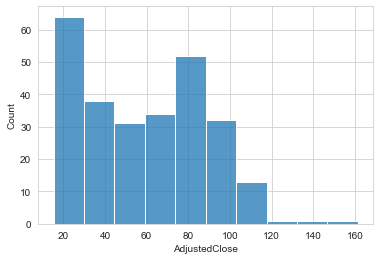

In [11]:
# check the distribution of our target column
sns.histplot(df_merge['AdjustedClose'])

It looks like the chevron stock price is not normally distributed.
The average price is falling somewhat around 60 dollars, with more price falling on 20 dollars.

In [12]:
# We want to know the yearly sales change 
# we need to group the rows by year
df_merge.groupby(['Year']).sum()

,Month,InflationRate,GasPrice,Sales,NetIncome,Assets,Equity,Volume,AdjustedClose
Year,,,,,,,,,
2000,78,40.5,18.294,47526.99,5184.99,495750.0,226830.0,459.414600,224.7643
2001,78,33.8,17.594,54343.02,1716.96,625740.0,302130.0,667.807600,245.1884
2002,78,19.0,16.582,93484.98,1132.02,928980.0,398370.0,731.539200,222.9465
2003,78,27.3,19.213,120031.98,7425.96,972090.0,418890.0,733.306700,209.9216
2004,78,32.2,22.695,146814.99,12688.02,1071390.0,504360.0,947.448650,296.2792
2005,78,40.6,27.746,193640.97,14098.98,1336470.0,654000.0,2082.211800,364.5763
2006,78,38.8,31.381,204891.99,17137.98,1577010.0,810870.0,2293.198000,416.4492
2007,78,34.4,34.146,214091.01,18687.99,1691910.0,893040.0,2511.090100,559.9599
2008,78,46.2,39.661,264957.99,23931.03,1928400.0,1005270.0,3900.184200,594.1090


<AxesSubplot:xlabel='Year', ylabel='Volume'>

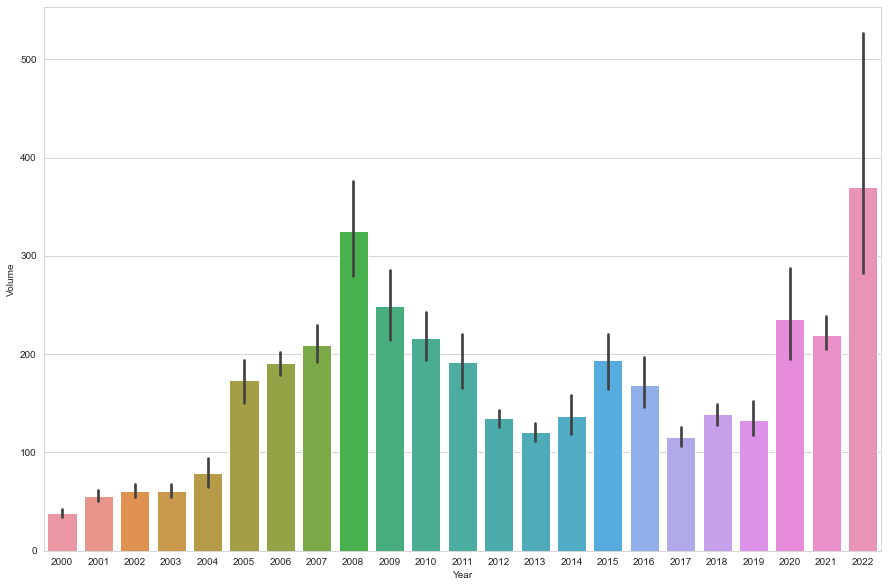

In [13]:
# let's plot the yearly sales change with a scatterplot
plt.figure(figsize=(15, 10))
sns.barplot(data=df_merge, x='Year', y='Volume')

#### Time Series Data Visualization

In [14]:
#add a new column named date to df_merge 
#assign day as 1 so that the datatype of date becomes datetime
#this column is for implementing time series plotting
df_merge['Date']=pd.to_datetime(df_merge[['Year', 'Month']].assign(Day=1))

In [15]:
#display the new dataframe
df_merge

,Year,Month,InflationRate,GasPrice,Sales,NetIncome,Assets,Equity,Volume,AdjustedClose,Date
0,2000,1,2.7,1.329,3481.00,348.00,41250.0,18010.0,37.687500,18.2953,2000-01-01
1,2000,2,3.2,1.415,3481.00,348.00,41250.0,18010.0,42.961800,16.4760,2000-02-01
2,2000,3,3.8,1.556,3481.00,348.00,41250.0,18010.0,51.176100,20.3915,2000-03-01
3,2000,4,3.1,1.506,3987.33,372.00,41380.0,18750.0,31.502600,18.7790,2000-04-01
4,2000,5,3.2,1.526,3987.33,372.00,41380.0,18750.0,30.692800,20.5234,2000-05-01
...,...,...,...,...,...,...,...,...,...,...,...
262,2021,11,6.8,3.491,15402.33,1685.00,239540.0,139940.0,224.686287,110.7529,2021-11-01
263,2021,12,7.0,3.406,15402.33,1685.00,239540.0,139940.0,221.128758,115.1489,2021-12-01
264,2022,1,7.5,3.413,17729.00,2086.33,249050.0,147100.0,300.049707,128.8667,2022-01-01
265,2022,2,7.9,3.611,17729.00,2086.33,249050.0,147100.0,282.783725,142.7935,2022-02-01


In [16]:
#create a new dataframe to store columns for time series analysis
#setting the Date as index
df_timeseries=df_merge[['Date','GasPrice', 'Sales', 'AdjustedClose']].set_index('Date')

#display the dataframe
df_timeseries

,GasPrice,Sales,AdjustedClose
Date,,,
2000-01-01,1.329,3481.00,18.2953
2000-02-01,1.415,3481.00,16.4760
2000-03-01,1.556,3481.00,20.3915
2000-04-01,1.506,3987.33,18.7790
2000-05-01,1.526,3987.33,20.5234
...,...,...,...
2021-11-01,3.491,15402.33,110.7529
2021-12-01,3.406,15402.33,115.1489
2022-01-01,3.413,17729.00,128.8667


In [17]:
# normalize all the column data and plot them together to see the different trends 
df_scaled = df_timeseries

# construct a scaler
scaler= MinMaxScaler()
df_scaled.iloc[:,:] = scaler.fit_transform(df_timeseries)

In [18]:
df_scaled

,GasPrice,Sales,AdjustedClose
Date,,,
2000-01-01,0.063224,0.000000,0.020562
2000-02-01,0.090141,0.000000,0.008116
2000-03-01,0.134272,0.000000,0.034902
2000-04-01,0.118623,0.021540,0.023871
2000-05-01,0.124883,0.021540,0.035805
...,...,...,...
2021-11-01,0.739906,0.507154,0.653071
2021-12-01,0.713302,0.507154,0.683144
2022-01-01,0.715493,0.606135,0.776988


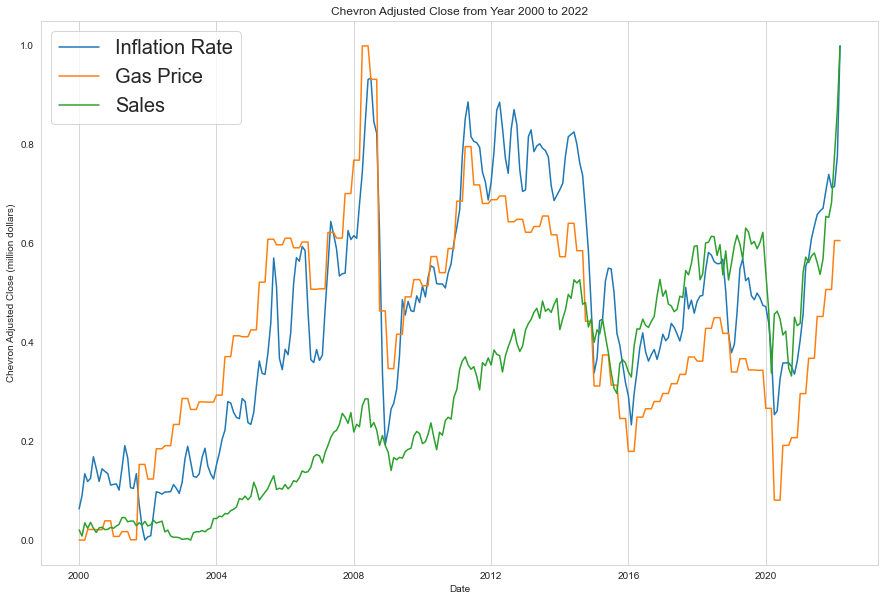

In [19]:
plt.figure(figsize=(15, 10))
plt.plot(df_scaled['GasPrice'])
plt.plot(df_scaled['Sales'])
plt.plot(df_scaled['AdjustedClose'])

plt.grid(axis='y')
plt.title('Chevron Adjusted Close from Year 2000 to 2022')
plt.xlabel('Date')
plt.ylabel('Chevron Adjusted Close (million dollars)')
plt.legend(['Inflation Rate', 'Gas Price', 'Sales', 'Adjusted Close'], prop={'size':20})
plt.show()

### Analyze the Relationship between Inflation and Stock Price
- Examine whether inflation rate can predict stock price
- Convert stock price to a percent change since inflation rate is a percent change

In [20]:
# create a list for monthly data
df_merge['AdjustedCloseChange']=df_merge['AdjustedClose']/df_merge['AdjustedClose'].shift(1)*100 - 100
df_change=df_merge[['Date', 'AdjustedCloseChange', 'InflationRate']].set_index('Date')

In [21]:
df_change

,AdjustedCloseChange,InflationRate
Date,,
2000-01-01,NaN,2.7
2000-02-01,-9.944084,3.2
2000-03-01,23.764870,3.8
2000-04-01,-7.907707,3.1
2000-05-01,9.289100,3.2
...,...,...
2021-11-01,-0.270411,6.8
2021-12-01,3.969196,7.0
2022-01-01,11.913097,7.5


In [22]:
# drop the first row that contains null value
df_change.drop(index='2000-01-01')

,AdjustedCloseChange,InflationRate
Date,,
2000-02-01,-9.944084,3.2
2000-03-01,23.764870,3.8
2000-04-01,-7.907707,3.1
2000-05-01,9.289100,3.2
2000-06-01,-8.194549,3.7
...,...,...
2021-11-01,-0.270411,6.8
2021-12-01,3.969196,7.0
2022-01-01,11.913097,7.5


### Visualize the infaltion rate and stock price change and their relationships

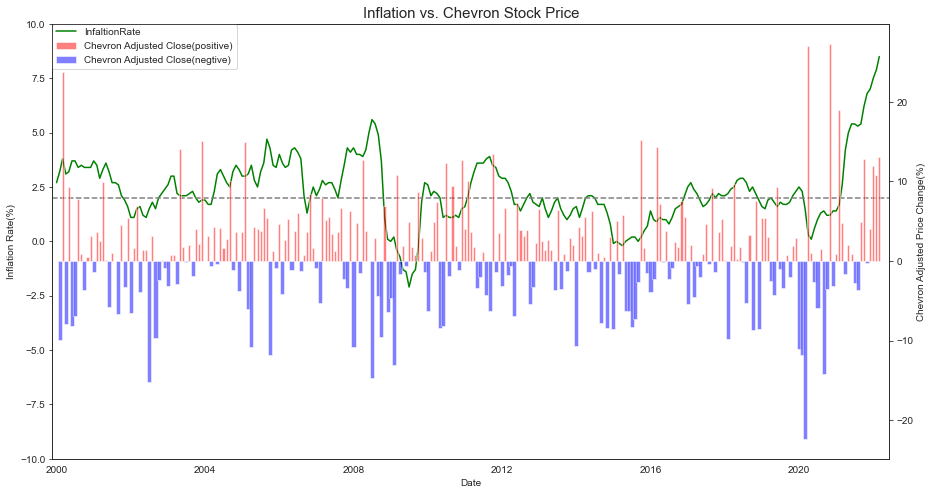

In [23]:
# set the style of the plot to be white
sns.set_style('white')

# set the figure size of the plot to be 15 width and 8 height
fig, ax1 = plt.subplots(figsize=(15, 8))

# create a twin axes sharing the xaxis
# create a new axes with an invisible x-axis and an independent y-axis positioned opposite to the original one
ax2 = ax1.twinx()

# plot inflation rate on ax1
ax1.plot(df_change.index, df_change.InflationRate,
         color="green", label="InfaltionRate")

#set positive adjusted close change as df_change_plus
df_change_plus=df_change[df_change['AdjustedCloseChange']>=0]

#position positive adjusted close change above x-axis
#set the line of color to be red
ax2.bar(df_change_plus.index, df_change_plus['AdjustedCloseChange'], 
       color='red', alpha=0.5, width=20, label='Chevron Adjusted Close(positive)')

#create a dataframe to store negative adjusted close change
df_change_minus = df_change[df_change['AdjustedCloseChange']<0]

#position negative adjusted close change below x-axis
#set the line of color to be blue
ax2.bar(df_change_minus.index, df_change_minus['AdjustedCloseChange'], 
       color='blue', alpha=0.5, width=40, label='Chevron Adjusted Close(negtive)')

#set a line of value 2 in ax1 as a baseline to see the deviation of inflation rate 
ax1.axhline(2, color='gray', linestyle='--')

#set the font size of tick labels
plt.tick_params(labelsize=10)  

#set title and fontsize
plt.title("Inflation vs. Chevron Stock Price", fontsize=15)

#get the handler and label of legend for ax1 and ax2
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

#set the corresponding legend for both ax1 and ax2
#set the location to be upper left, which is location code 2
#set the pad between the axes and legend border to be 0
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

#set x label to be Date
ax1.set_xlabel("Date")

#set y label for ax1
ax1.set_ylabel("Inflation Rate(%)")

#set y label for ax2
ax2.set_ylabel("Chevron Adjusted Price Change(%)")

#set ylim for ax1
ax1.set_ylim([-10, 10])

#set xlim for ax1, add a little time difference from both the left and right y-axis
ax1.set_xlim([min(df_change.index) - dt.timedelta(days=40),
              max(df_change.index) + dt.timedelta(days=100)])

#display the plot
plt.show()

- Both inflation rate and Chevron stock price are volatile. 
- The inflation rate is positive most of the time, but plummets after year 2008 to a negative value. It increases dramatically after year 2020 to an unprecedented high value.
- The Chevron stock price change has more positive values than negative values, meaning it is increasing generally.However, it plummets in 2020 and rebounces in 2022. 
- Although it appears that blue bars appear when inflation is bad, red bars are also present.

In [24]:
change_scaler = MinMaxScaler(feature_range=(-1,1))
df_change2 = df_change.copy()
df_change2.iloc[:,:] = change_scaler.fit_transform(df_change2)
df_change2

,AdjustedCloseChange,InflationRate
Date,,
2000-01-01,NaN,-9.433962e-02
2000-02-01,-0.499646,1.110223e-16
2000-03-01,0.857734,1.132075e-01
2000-04-01,-0.417646,-1.886792e-02
2000-05-01,0.274829,1.110223e-16
...,...,...
2021-11-01,-0.110110,6.792453e-01
2021-12-01,0.060609,7.169811e-01
2022-01-01,0.380491,8.113208e-01


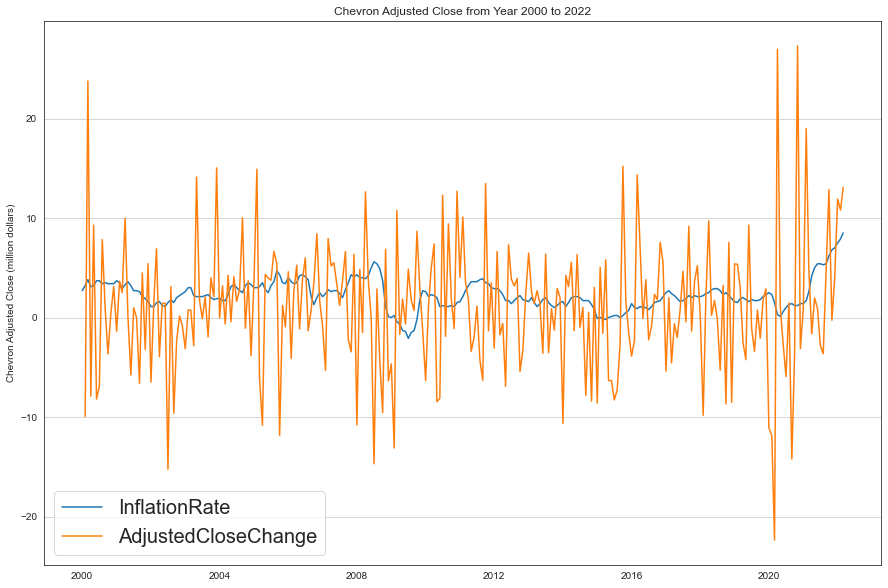

In [25]:

plt.figure(figsize=(15, 10))
plt.plot(df_change['InflationRate'])
plt.plot(df_change['AdjustedCloseChange'])
plt.grid(axis='y')
plt.title('Chevron Adjusted Close from Year 2000 to 2022')

plt.ylabel('Chevron Adjusted Close (million dollars)')
plt.legend(['InflationRate', 'AdjustedCloseChange'], prop={'size':20})
plt.show()


As you can see stock market is way more volitile than inflation.

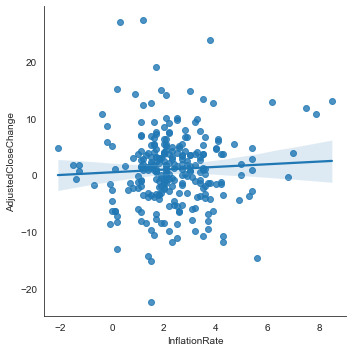

In [26]:
# Let's draw a linear regression plot to examine the relationship between inflation rate and adjusted close change
sns.lmplot(x='InflationRate', y='AdjustedCloseChange', data=df_change)

 The trend line shows that there is a positive correlation between inflation rate and chevson stock price change. When inflation rate increases, the adjusted close change increases. However, the correlation is very weak. When inflation rate is high, it doesn't necessarily mean the stock performance is good.

#### Draw a pairplot

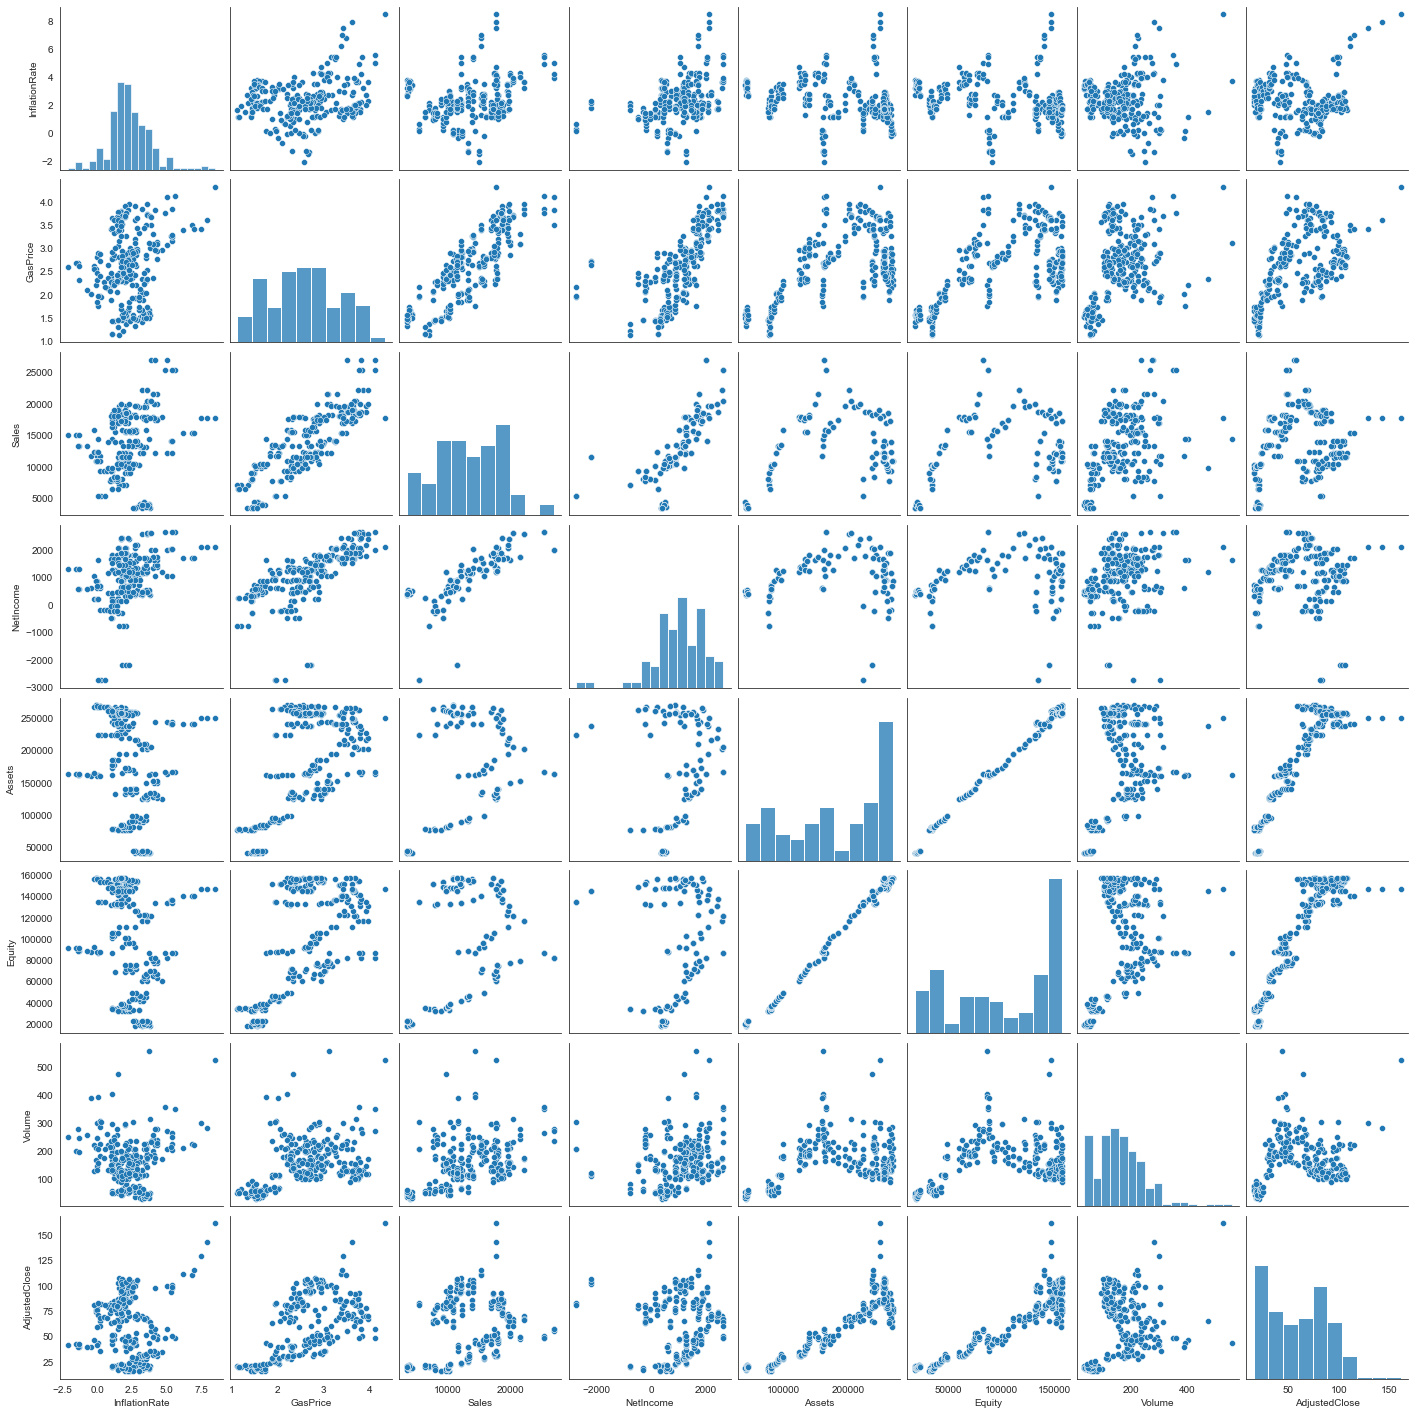

In [27]:
# create a column variable to store the columns that we want to retrieve
cols = ['InflationRate', 'GasPrice', 'Sales', 'NetIncome', 'Assets','Equity','Volume','AdjustedClose'] 

# create a pairplot to visualze the relationship between any two columns
sns.pairplot(df_merge[cols], height = 2.5)

# show the plot
plt.show()

- The adjusted close has positive correlation with gas price, sales, net income, assets and equity. 
- Let's draw a heatmap to see how strong they are correlated.

Text(0.5, 1.0, 'Heatmap - Correlation')

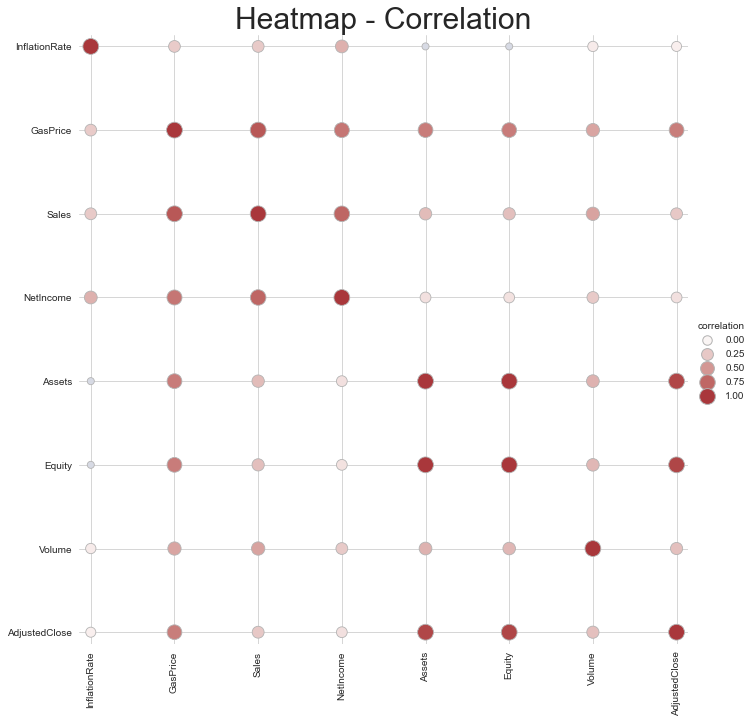

In [28]:
# plot a heatmap to explicitly show the correlation between any two features
# Compute a correlation matrix and convert to long-form
corr_mat = df_merge[cols].corr().stack().reset_index(name="correlation")
sns.set_style('whitegrid')
# Draw each cell as a scatter point with varying size and color
g = sns.relplot(data=corr_mat,x="level_0", y="level_1", hue="correlation", size="correlation",palette="vlag", hue_norm=(-1, 1), edgecolor=".7",height=10, sizes=(50, 250), size_norm=(-.2, .8),)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")
plt.title('Heatmap - Correlation', fontsize=30)

- The Chevron sales has a strong correlation with gas price.
- The adjusted close has moderate to strong correlation with gas price, assets, and equity.

In [29]:
df_merge.head()

,Year,Month,InflationRate,GasPrice,Sales,NetIncome,Assets,Equity,Volume,AdjustedClose,Date,AdjustedCloseChange
0,2000,1,2.7,1.329,3481.00,348.0,41250.0,18010.0,37.6875,18.2953,2000-01-01,NaN
1,2000,2,3.2,1.415,3481.00,348.0,41250.0,18010.0,42.9618,16.4760,2000-02-01,-9.944084
2,2000,3,3.8,1.556,3481.00,348.0,41250.0,18010.0,51.1761,20.3915,2000-03-01,23.764870
3,2000,4,3.1,1.506,3987.33,372.0,41380.0,18750.0,31.5026,18.7790,2000-04-01,-7.907707
4,2000,5,3.2,1.526,3987.33,372.0,41380.0,18750.0,30.6928,20.5234,2000-05-01,9.289100


In [53]:

# create gallons Sold
df_merge['RegSales'] = (df_merge.Sales * 3) / 1000
df_merge['GallonsSold'] = (df_merge.RegSales/df_merge.GasPrice)
df_merge.GallonsSold = df_merge.GallonsSold.astype(int)
df_merge['DateYM'] = pd.to_datetime(df_merge.Date).dt.to_period('M')
df_merge.head(1)


,Year,Month,InflationRate,GasPrice,Sales,NetIncome,Assets,Equity,Volume,AdjustedClose,Date,AdjustedCloseChange,GallonsSold,DateYM,RegSales
0,2000,1,2.7,1.329,3481.0,348.0,41250.0,18010.0,37.6875,18.2953,2000-01-01,NaN,7,2000-01,10.443


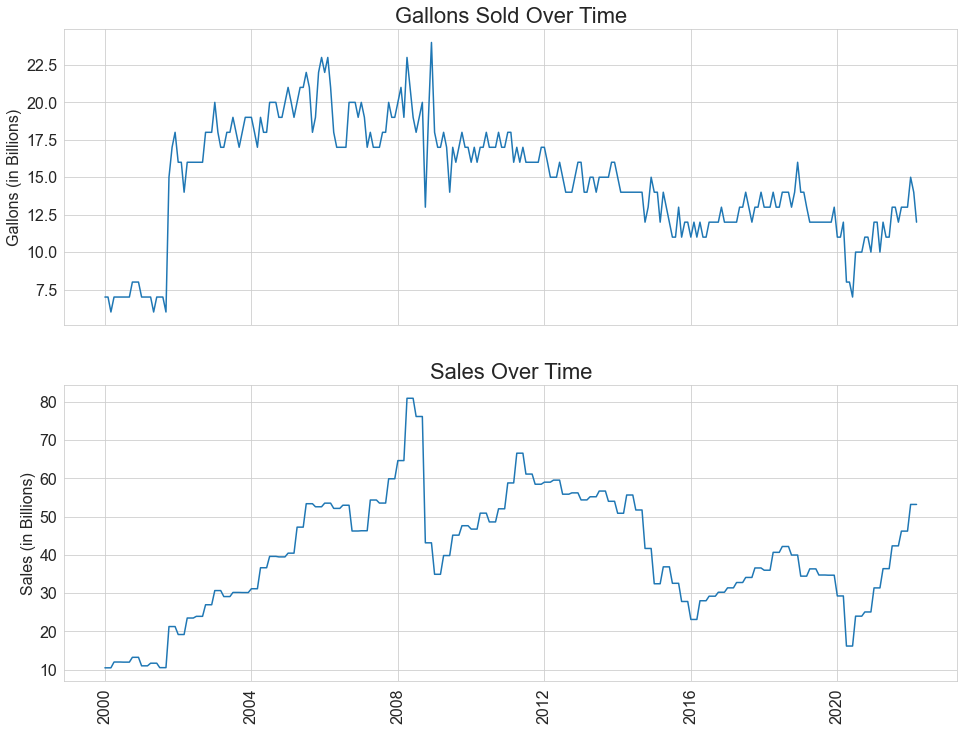

In [54]:
fig, (axes1,axes2) = plt.subplots(2,1,figsize=(16,12),sharex=True)
# plt.tick_params(axis='both', which='major', labelsize=22)
plt.subplot(2,1,1)
# plt.subplots_adjust(wspace=.9,hspace=2)
axes1.plot(df_merge.Date, df_merge.GallonsSold)
axes1.set_title('Gallons Sold Over Time',fontsize=22)
axes1.set_ylabel('Gallons (in Billions)', fontsize = 16)
axes1.tick_params(axis='both', which='both',labelsize=16)

axes2.plot(df_merge.Date, df_merge.RegSales)
axes2.set_title('Sales Over Time',fontsize=22)
axes2.set_ylabel('Sales (in Billions)', fontsize = 16)
axes2.tick_params(axis='both', which='both',labelsize=16)
axes2.tick_params(axis='x', labelrotation=90)

The Gallons of Gas is declining slowly, in the recent price hike, the consumption of gallons of gas decreased.

## Machine Learning


### Build Linear Regression Model to Predict Stock Price

In [56]:
# Build linear regression model using gas price, assets and equity as predictors
# Split data into predictors X and output y
predictors = ['GasPrice', 'Assets', 'Equity']
X = df_merge[predictors]
y = df_merge['AdjustedClose']

In [57]:
# split the dataset into training and testing data to verify the model
# test_size indicates the % of data placed in the test split

# since this is times series, we should not shuffle it, and not set random state
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.3, shuffle = False)

In [58]:
# Initialize and fit model
lm = LinearRegression()
# train the linear regression model using the training data
lm.fit(X_train_reg, y_train_reg)

LinearRegression()

In [59]:
# use lm.predict() to predict off the X_test set of the data
y_pred_reg = lm.predict(X_test_reg)
y_pred_reg

array([77.06433649, 76.25970633, 74.88034034, 73.40899765, 72.74543901,
       72.13935396, 70.28727941, 69.32067824, 70.3604276 , 69.13962299,
       69.94947802, 70.45106565, 69.91621828, 69.59750114, 69.8221706 ,
       68.92511399, 68.59072224, 68.96168809, 70.56717452, 70.34772993,
       70.45745223, 71.7576859 , 71.62706412, 71.40239466, 71.4450944 ,
       71.86308409, 73.2581247 , 74.0271967 , 74.32501436, 73.88612518,
       75.46026737, 75.63791299, 75.65881248, 77.61826347, 78.21389878,
       78.12507597, 79.30017421, 79.22702602, 79.23225089, 80.87629237,
       79.79474404, 78.33700498, 77.3547145 , 77.64208241, 78.69228152,
       81.51947462, 81.85909124, 81.11715954, 80.58882121, 79.98273615,
       79.8468895 , 75.38317263, 75.22120162, 74.9704078 , 74.86919478,
       74.33103305, 73.26515933, 65.9945832 , 66.11475524, 67.20675332,
       65.9006725 , 65.9006725 , 65.91112224, 62.0652028 , 61.81440898,
       62.25329816, 62.65244243, 63.52499592, 65.14993085, 65.91

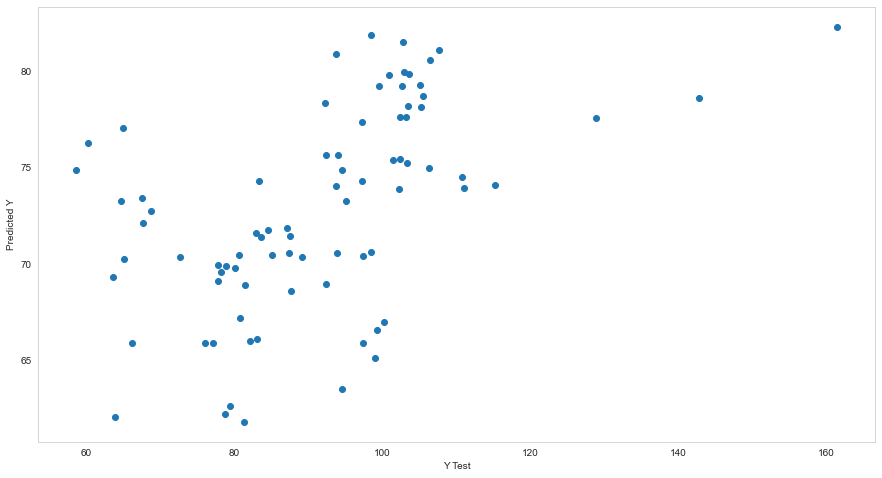

In [60]:
#create a scatterplot of the real test values versus the predicted values
plt.figure(figsize=(15, 8))
plt.scatter(x=y_test_reg, y=y_pred_reg)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.grid()

#### Evaluate the model

In [195]:
#calculate the Mean Absolute Error, Mean Squared Error, and the Root Mean Squared Error
print('MAE:', metrics.mean_absolute_error(y_test_reg, y_pred_reg))
print('MSE:', metrics.mean_squared_error(y_test_reg, y_pred_reg))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_reg)))
print('R2 Score:', r2_score(y_test_reg, y_pred_reg))

MAE: 7.449517654426383
MSE: 142.5387004975616
RMSE: 11.938957261736117
R2 Score: 0.8604948818853534


### Load Data / Features

In [62]:
# load final df
dfmerge3 = pd.read_csv('data/df_final_merge.csv',index_col=0)

dffinal = dfmerge3
dffinal.head()

,Year,Month,InflationRate,GasPrice,Sales,NetIncome,Assets,Equity,Volume,AdjustedClose
0,2000,1,2.7,1.329,3481.00,348.0,41250.0,18010.0,37.6875,18.2953
1,2000,2,3.2,1.415,3481.00,348.0,41250.0,18010.0,42.9618,16.4760
2,2000,3,3.8,1.556,3481.00,348.0,41250.0,18010.0,51.1761,20.3915
3,2000,4,3.1,1.506,3987.33,372.0,41380.0,18750.0,31.5026,18.7790
4,2000,5,3.2,1.526,3987.33,372.0,41380.0,18750.0,30.6928,20.5234


In [63]:
############################## MANUAL Train Test Split ##############################
# Since this is Time Series, we need split manually
# calculate train_size and test_size
train_size = int(len(dffinal)*0.8)
test_size = len(dffinal)-train_size

# split df 
traindf, testdf = dffinal.iloc[0:train_size], dffinal.iloc[train_size:]

# columns needed
featureColumns = ['NetIncome','Equity','GasPrice']
targetColumns = ['AdjustedClose']

# Since data has wide range, apply Standard Scale
# X Scaler
featureScaler = StandardScaler()
X_train = traindf[featureColumns] = featureScaler.fit_transform(traindf[featureColumns].to_numpy())
X_test = testdf[featureColumns] = featureScaler.transform(testdf[featureColumns].to_numpy())

# y Scaler
targetScaler = StandardScaler()
y_train = traindf[targetColumns] = targetScaler.fit_transform(traindf[targetColumns])
y_test = testdf[targetColumns] = targetScaler.transform(testdf[targetColumns])



In [98]:
# saving to pickle file
with open('output/featureScaler.pickle', 'wb') as handle1:
    pickle.dump(featureScaler, handle1, protocol=pickle.HIGHEST_PROTOCOL)

with open('output/targetScaler.pickle', 'wb') as handle2:
    pickle.dump(targetScaler, handle2, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
# Convert dimension for LSTM
Xt, yt = convSeq(traindf[featureColumns], traindf[targetColumns],6)

Xv, yv = convSeq(testdf[featureColumns], testdf[targetColumns] ,6)

print(X_train.shape)
print(Xt.shape)

(213, 3)
(207, 6, 3)


### Machine Learning

In [65]:
linear = LinearRegression()
ridge = Ridge()
randomForest = RandomForestRegressor()
xgb = XGBRegressor()


In [66]:
runML(linear,X_train,y_train,X_test,y_test)
runML(ridge,X_train,y_train,X_test,y_test)
runML(randomForest,X_train,y_train,X_test,y_test)
runML(xgb,X_train,y_train,X_test,y_test)

LinearRegression()
MAE score: 0.9271496729554565
MSE score: 1.151998081648884
R2 score: -1.5612892097385478

Ridge()
MAE score: 0.9319955936396292
MSE score: 1.1614463406598476
R2 score: -1.5822959494554736

RandomForestRegressor()
MAE score: 0.8745202497947291
MSE score: 1.0285795487462044
R2 score: -1.2868872279635974

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lam

### Deep Learning

#### ANN

In [67]:
# since ANN takes two dimension, we use X_train
# Features and optimizers
optimizer = 'rmsprop'

# Model
ann = Sequential()

# Hidden layer 1
ann.add(Flatten(input_shape= (traindf[featureColumns].shape[1], 1)))
ann.add(Dense(16))
ann.add(LeakyReLU(alpha=0.05))

# Hidden layer 2
ann.add(Dense(4))
ann.add(LeakyReLU(alpha=0.05))

# output layer
ann.add(Dense(1))

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
ann.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae'])

# model summary
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 16)                64        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 137
Trainable params: 137
Non-trainable pa

In [68]:
history = ann.fit(traindf[featureColumns], traindf[targetColumns], epochs=50, batch_size=2, validation_data=(testdf[featureColumns], testdf[targetColumns]),verbose=1)

Epoch 1/50
107/107 [==============================] - 1s 4ms/step - loss: 0.7743 - mse: 0.7743 - mae: 0.7690 - val_loss: 2.8847 - val_mse: 2.8847 - val_mae: 1.6031
Epoch 2/50
107/107 [==============================] - 0s 2ms/step - loss: 0.5281 - mse: 0.5281 - mae: 0.6073 - val_loss: 1.6919 - val_mse: 1.6919 - val_mae: 1.1634
Epoch 3/50
107/107 [==============================] - 0s 2ms/step - loss: 0.3628 - mse: 0.3628 - mae: 0.4901 - val_loss: 1.3663 - val_mse: 1.3663 - val_mae: 1.0429
Epoch 4/50
107/107 [==============================] - 0s 3ms/step - loss: 0.2145 - mse: 0.2145 - mae: 0.3725 - val_loss: 1.2276 - val_mse: 1.2276 - val_mae: 0.9998
Epoch 5/50
107/107 [==============================] - 0s 2ms/step - loss: 0.1014 - mse: 0.1014 - mae: 0.2531 - val_loss: 1.1275 - val_mse: 1.1275 - val_mae: 0.9621
Epoch 6/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0641 - mse: 0.0641 - mae: 0.1879 - val_loss: 1.0628 - val_mse: 1.0628 - val_mae: 0.9025
Epoch 7/50
107/1

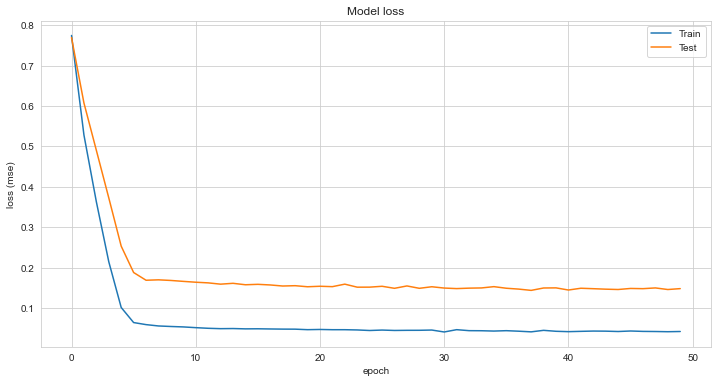

In [69]:
plt.figure(figsize=(12,6))
plt.plot(ann.history.history['loss'][:])
plt.plot(ann.history.history['mae'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.legend(['Train', 'Test'], loc='upper right')

In [70]:
# NN - this model takes in 3 dimension
inputs = Input(shape=(Xt.shape[1], Xt.shape[2]))
x = Flatten()(inputs)
x = Dense(16, activation=LeakyReLU(alpha=0.05))(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.summary()

model.compile(optimizer=optimizer, loss="mse", metrics=['mse',"mae"])
history = model.fit(Xt, yt, epochs=50)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 flatten_1 (Flatten)         (None, 18)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                304       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.6967 - mse: 0.6967 - mae: 0.6092
Epoch 2/50
7/7 [==============================] - 0s 2ms/step - loss: 0.4074 - mse: 0.4074

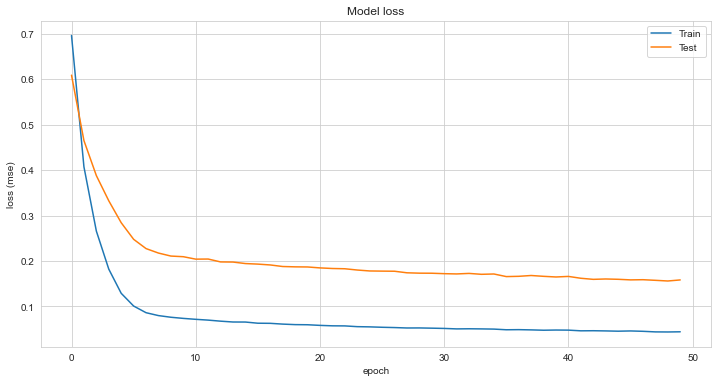

In [71]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['mae'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.legend(['Train', 'Test'], loc='upper right')

#### LSTM

In [99]:
optimizer = 'adam'

# Model
lstm = Sequential()

# # Hideen layers
lstm.add(LSTM(units=16,activation = LeakyReLU(alpha=0.05), return_sequences = True, input_shape= (Xt.shape[1], Xt.shape[2])))
lstm.add(LSTM(units=8,activation = LeakyReLU(alpha=0.05),input_shape= (Xt.shape[1], 16)))
lstm.add(Dense(units=3, activation = LeakyReLU(alpha=0.05)))
lstm.add(Dense(units=1, activation = LeakyReLU(alpha=0.05)))

checkpoint = ModelCheckpoint('output/lstm.h5', monitor='mse', save_best_only=True, verbose=1)

lstm.compile(optimizer=optimizer, loss='mse',metrics=['mse','mae'])
lstm.summary()
history = lstm.fit(Xt, yt, epochs=50, batch_size=2,verbose=1, callbacks=checkpoint)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 6, 16)             1280      
                                                                 
 lstm_18 (LSTM)              (None, 8)                 800       
                                                                 
 dense_30 (Dense)            (None, 3)                 27        
                                                                 
 dense_31 (Dense)            (None, 1)                 4         
                                                                 
Total params: 2,111
Trainable params: 2,111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 99/104 [===========================>..] - ETA: 0s - loss: 0.7397 - mse: 0.7397 - mae: 0.7351
Epoch 1: mse improved from inf to 0.73403, saving model to output\lstm.h5
104/

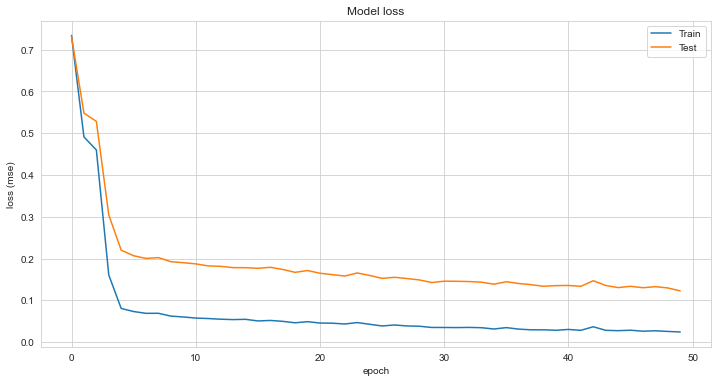

In [100]:
plt.figure(figsize=(12,6))
plt.plot(lstm.history.history['loss'][:])
plt.plot(lstm.history.history['mae'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.legend(['Train', 'Test'], loc='upper right')

In [74]:
inputs = Input(shape=(Xt.shape[1], Xt.shape[2]))
x = LSTM(16)(inputs)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=['mse',"mae"])
history = model.fit(Xt,yt,epochs=50)

Epoch 1/50
7/7 [==============================] - 2s 4ms/step - loss: 0.6062 - mse: 0.6062 - mae: 0.6789
Epoch 2/50
7/7 [==============================] - 0s 3ms/step - loss: 0.4419 - mse: 0.4419 - mae: 0.5642
Epoch 3/50
7/7 [==============================] - 0s 4ms/step - loss: 0.3479 - mse: 0.3479 - mae: 0.4940
Epoch 4/50
7/7 [==============================] - 0s 3ms/step - loss: 0.2792 - mse: 0.2792 - mae: 0.4285
Epoch 5/50
7/7 [==============================] - 0s 4ms/step - loss: 0.2216 - mse: 0.2216 - mae: 0.3695
Epoch 6/50
7/7 [==============================] - 0s 3ms/step - loss: 0.1764 - mse: 0.1764 - mae: 0.3212
Epoch 7/50
7/7 [==============================] - 0s 3ms/step - loss: 0.1387 - mse: 0.1387 - mae: 0.2803
Epoch 8/50
7/7 [==============================] - 0s 4ms/step - loss: 0.1106 - mse: 0.1106 - mae: 0.2507
Epoch 9/50
7/7 [==============================] - 0s 4ms/step - loss: 0.0887 - mse: 0.0887 - mae: 0.2223
Epoch 10/50
7/7 [==============================] - 0s 4

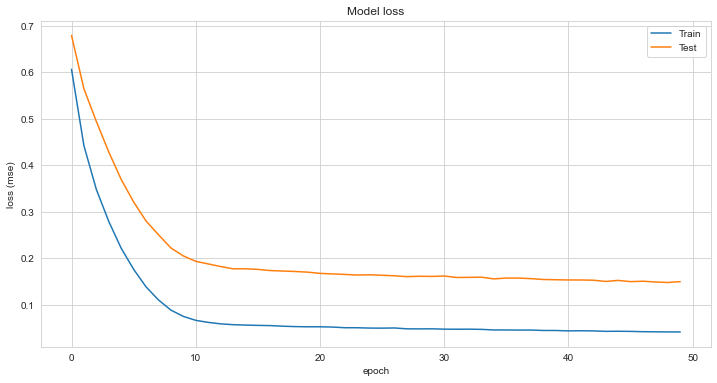

In [75]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['mae'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.legend(['Train', 'Test'], loc='upper right')

#### RNN Bidirectional LSTM

In [105]:
biLSTM = Sequential()
# biLSTM.add(Bidirectional(LSTM(units=64,dropout=0.5, recurrent_dropout=0.5),input_shape=(Xt.shape[1], Xt.shape[2])))
biLSTM.add(Bidirectional(LSTM(units=64),input_shape=(Xt.shape[1],Xt.shape[2])))
biLSTM.add(Dense(units=32, activation='swish'))
biLSTM.add(Dense(units=16, activation='swish'))
biLSTM.add(Dense(units=8, activation='swish'))
biLSTM.add(Dense(units=1, activation='swish'))

biLSTM.compile(optimizer=optimizer, loss='mse', metrics=['mse','mae'])

biLSTM.summary()

history = biLSTM.fit(Xt, yt, epochs=50, batch_size=2,verbose=1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 128)              34816     
 nal)                                                            
                                                                 
 dense_32 (Dense)            (None, 32)                4128      
                                                                 
 dense_33 (Dense)            (None, 16)                528       
                                                                 
 dense_34 (Dense)            (None, 8)                 136       
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 39,617
Trainable params: 39,617
Non-trainable params: 0
_________________________________________________

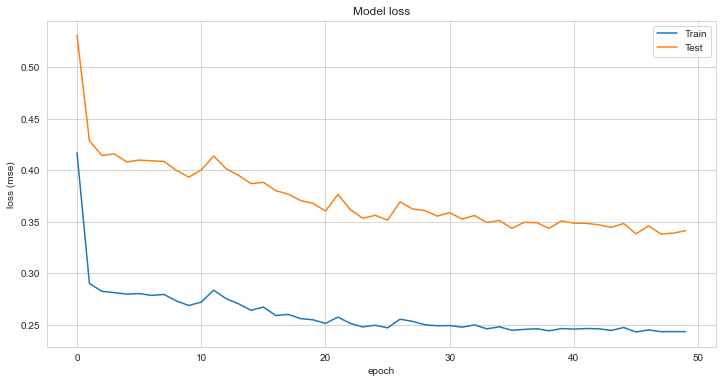

In [106]:
plt.figure(figsize=(12,6))
plt.plot(biLSTM.history.history['loss'][:])
plt.plot(biLSTM.history.history['mae'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.legend(['Train', 'Test'], loc='upper right')

#### Hyperparameters

#### Predict

In [107]:
# y_predict using Bidirectional LSTM model
y_predict = biLSTM.predict(Xv)
yt_inverse = targetScaler.inverse_transform(yt.reshape(1,-1))
yv_inverse = targetScaler.inverse_transform(yv.reshape(1,-1))
y_predict_inv = targetScaler.inverse_transform(y_predict)

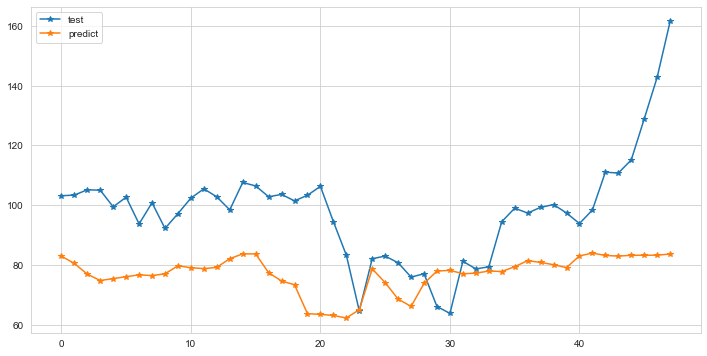

In [108]:
plt.figure(figsize=(12,6))
plt.plot(yv_inverse.flatten(),marker = '*', label='test')
plt.plot(y_predict_inv.flatten(),marker = '*', label='predict')
plt.legend()

## Conclusion


## References


----------
CIS43 Project Link<br>
https://colab.research.google.com/drive/1OS0i9lEitkL7PTE7TpLuWVoqkjS0BPYC
<br>

Load local file onto colab<br>
https://www.youtube.com/watch?v=6HFlwqK3oeo
<br>
<br>

----------
Inflation Data<br>
https://www.usinflationcalculator.com/inflation/current-inflation-rates/#:~:text=The%20annual%20inflation%20rate%20for,at%208%3A30%20a.m.%20ET.
<br>
<br>
Gas Prices<br>
https://www.kaggle.com/datasets/mruanova/us-gasoline-and-diesel-retail-prices-19952021
<br>
<br>